In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import ptitprince as pt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from src.d01_data.fetch.group_conditions import group_conditions
from src.d01_data.fetch.fetch_conditions import fetch_conditions
from src.d02_intermediate.df_reshaping import add_col_by_lookup
# from data import d01_raw
from src.d04_wrangling.add_ppt_info import *


In [7]:
dwellT_nfixF = True   # shouldn't use both dwell and n/p fix because highly collinear
HnT_dF = True   

# file_loc = "C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\alloeye_conditions.csv"
# df = pd.read_csv(file_loc)
df = fetch_conditions("all")
df = add_ppt_info(df)
# add group and NP testing columns
# pd.set_option('mode.chained_assignment', None)
# drop_cols = ['Notes', 'dob', 'occupation']
# pid_info = pd.read_csv(f"{os.path.abspath(d01_raw.__path__[0])}\ppt_info_alloeye.csv")
# pid_info['pid'] = pid_info.pid.apply(lambda s: 'alloeye_' + str(s))
# info_cols = pid_info.columns
# df = add_col_by_lookup(df, 'group', 'ppt_id', pid_info, 'pid', 'group')


# replace ppt_id with random integers to avoid any effect of id number
pid_rand = np.random.default_rng().choice(len(df), size=len(df), replace=False)
# df.ppt_id = pid_rand
# wrangle some columns
def drop_col_with(df, string):
    for col in df.columns:
        if string in col:
            df = df.drop([col], axis=1)
    return df 

df = drop_col_with(df, 'Unnamed')
drop_cols = ['n_correct', 'n_trials', 'pupil_diam_centre_enc', 'pupil_diam_centre_ret',
            'pupil_diam_spread_ret', 'pupil_diam_spread_enc']
df = df.drop(drop_cols, axis=1)

# drop entropy 
e_drop = 'hd' if HnT_dF else 'hn'
df = drop_col_with(df, e_drop)

# remove sacc for now
df = drop_col_with(df, 'sacc')

# remove velocity for now
df = drop_col_with(df, 'velocity')

# remove old blinks
df = drop_col_with(df, 'dur_blinks')

# dwell comparison
df['dwell_notMoved_enc'] = df['dwell_obj2_enc'] + df['dwell_obj3_enc'] + df['dwell_obj4_enc']
df['dwell_notMoved_ret'] =  df['dwell_obj2_ret'] + df['dwell_obj3_ret'] + df['dwell_obj4_ret']
df['redwell_notMoved_enc'] = df['redwell_obj2_enc'] + df['redwell_obj3_enc'] + df['redwell_obj4_enc']
df['redwell_notMoved_ret'] =  df['redwell_obj2_ret'] + df['redwell_obj3_ret'] + df['redwell_obj4_ret']
df['refix_notMoved_enc'] =  df['n_refix_obj2_enc'] + df['n_refix_obj3_enc'] + df['n_refix_obj4_enc']
df['refix_notMoved_ret'] =  df['n_refix_obj2_ret'] + df['n_refix_obj3_ret'] + df['n_refix_obj4_ret']
df['dwell_MOminusSOs_enc'] = df['dwell_obj1_enc'] - df['dwell_notMoved_enc']
df['dwell_MOminusSOs_ret'] = df['dwell_obj1_ret'] - df['dwell_notMoved_ret']

df['dwell_MOminusTable_ret'] = df['dwell_obj1_ret'] - df['dwell_table_ret']
df['dwell_array_enc'] = df['dwell_obj1_enc'] + df['dwell_notMoved_enc']
df['dwell_array_ret'] = df['dwell_obj1_ret'] + df['dwell_notMoved_ret']

# dwell time as proportion
for col in df.columns:
    if 'dwell' in col and 'total' not in col and 'gini' not in col and 'gauss' not in col:
        if 'ret' in col:
            df[col] /= df['dwell_total_ret']
        else:
            df[col] /= df['dwell_total_enc']

eps = 0.001
df['dwell_MOSOs_ratio_ret'] = df['dwell_obj1_ret'] / df['dwell_notMoved_ret']
df['dwell_tableSOs_ratio_ret'] = df['dwell_table_ret'] / df['dwell_notMoved_ret']
df['dwell_MOtabletoSOs_ratio_ret'] = (df['dwell_obj1_ret'] + df['dwell_table_ret'] ) / df['dwell_notMoved_ret']
df['redwell_MOtabletoSOs_ratio_ret'] = (df['redwell_obj1_ret'] + df['redwell_table_ret'] + eps ) / (df['redwell_notMoved_ret'] + eps)
df['refix_MOtabletoSOs_ratio_ret'] = (df['n_refix_obj1_ret'] + df['n_refix_table_ret'] + eps) / (eps + df['refix_notMoved_ret'])
df['dwell_MOPPtabletoSOs_ratio_ret'] = (df['dwell_obj1_ret'] + df['dwell_table_ret'] + df['dwell_pp_ret'] ) / df['dwell_notMoved_ret']
df['dwell_MOtabletoSOs_logratio_ret'] = np.log(df['dwell_MOtabletoSOs_ratio_ret'])
df['redwell_MOtabletoSOs_logratio_ret'] = np.log(df['redwell_MOtabletoSOs_ratio_ret'])
df['refix_MOtabletoSOs_logratio_ret'] = np.log(df['refix_MOtabletoSOs_ratio_ret'])
df['dwell_MOSOs_logratio_ret'] = np.log(df['dwell_MOSOs_ratio_ret'])
df['dwell_tableSOs_logratio_ret'] = np.log(df['dwell_tableSOs_ratio_ret'])
df['dwell_MOPPtabletoSOs_logratio_ret'] = np.log(df['dwell_MOPPtabletoSOs_ratio_ret'])

df['dwell_odds_obj1_ret'] = df['dwell_obj1_ret']/(df['dwell_total_ret'] - df['dwell_obj1_ret'])
df['dwell_odds_table_ret'] = df['dwell_table_ret']/(df['dwell_total_ret'] - df['dwell_table_ret'])
df['dwell_logodds_obj1_ret'] = np.log(df['dwell_odds_obj1_ret'])
df['dwell_logodds_table_ret'] = np.log(df['dwell_odds_table_ret'])
df['dwell_tablearray_ratio_ret'] = df['dwell_table_ret'] / df['dwell_array_ret']
df['dwell_tablearray_logratio_ret'] = np.log(df['dwell_tablearray_ratio_ret'] )
df['dwell_obj1table_logOR_ret'] = np.log(df['dwell_odds_obj1_ret'] / df['dwell_odds_table_ret'])

# drop obj2-4 cols
for col in df.columns:
    if'obj' in col:
        if '2' in col or '3' in col or '4' in col:
            df = df.drop([col], axis=1)

# p fixations - NEED TO DEAL WITH INFINITIES CAUSED BY DIFF - DIVIDING BY 0
for col in df.columns:
    if 'n_fix' in col and 'total' not in col and 'diff' not in col:
        rem = col.split('n_fix')[-1]
        view = rem.split('_')[-1]
        new_col = 'p_fix'+rem
        total = 'n_fix_total_'+view
        df[new_col] = df[col] / df[total]
        df = df.drop([col], axis=1)
for col in df.columns:
    if 'n_fix' in col and 'total' in col:
        df = df.drop([col], axis=1)

#
# # dwell time as proportion
# for col in df.columns:
#     if 'dwell' in col:
#         df[col] /= 7000
        
# sort 4MT
first_col = 0
col_saved = False
for col in df.columns:
    if '4MT' in col:
        nas = pd.isna(df[col])
        # print(sum(nas))
        if 'RT' not in col:
            df[col] = np.where(df[col] == 'CORRECT', 1, 0)
            if col_saved is False:
                first_col = df.columns.get_loc(col)
                col_saved = True
        df[col][nas] = np.nan
df['4MT'] = df.iloc[:, first_col:first_col+15].sum(axis=1)
df = drop_col_with(df, '4MT_T')

# neuropsych wrangling
# df['FCSRT_FR_I'] = df['FCSRT T1 FR'] + df['FCSRT T2 FR'] + df['FCSRT T3 FR']
# df['FCSRT_TR_I'] = df['FCSRT T1 TR'] + df['FCSRT T2 TR'] + df['FCSRT T3 TR']
df = drop_col_with(df, 'FCSRT T')

# choose either dwell or p fix
# if dwellT_nfixF is True:
#     df = drop_col_with(df, 'fix')
# else:
#     df = drop_col_with(df, 'dwell')
    
df = df.drop(['condition_id', 'study_id'], axis=1)

display(df.head(20).style)

haven't written this function yet!


C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d01_data\fetch\fetch_conditions.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(query, conn)
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_10608\2261283669.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['dwell_MOSOs_ratio_ret'] = df['dwell_obj1_ret'] / df['dwell_notMoved_ret']
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_10608\2261283669.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

,ppt_id,condition,p_correct,hn_enc,dwell_total_enc,dwell_obj1_enc,dwell_table_enc,dwell_other_enc,t_first_array_enc,t_first_obj1_enc,hn_ret,dwell_total_ret,dwell_obj1_ret,dwell_table_ret,dwell_other_ret,t_first_array_ret,t_first_obj1_ret,hn_diff,n_fix_obj1_diff,n_fix_table_diff,n_fix_other_diff,dwell_total_diff,dwell_obj1_diff,dwell_table_diff,dwell_other_diff,t_first_array_diff,t_first_obj1_diff,pupil_diam_centre_diff,pupil_diam_spread_diff,dwell_pp_enc,dispersion_mean_enc,drop_out_total_enc,dwell_pp_ret,dispersion_mean_ret,drop_out_total_ret,n_fix_pp_diff,dwell_pp_diff,dispersion_mean_diff,drop_out_total_diff,d_kl,ea_td,n_blinks_enc,n_blinks_ret,n_blinks_diff,mean_confidence,p_trackloss_enc,p_trackloss_ret,p_trackloss_diff,ht_enc,n_transitions_enc,ht_ret,n_transitions_ret,ht_diff,n_transitions_diff,distance_obj1_median_enc,distance_pp_median_enc,distance_border_median_enc,distance_obj1_median_ret,distance_pp_median_ret,distance_border_median_ret,distance_obj1_median_diff,distance_pp_median_diff,distance_border_median_diff,gini_fix_enc,gini_dwell_enc,gini_refix_enc,gini_redwell_enc,gini_fix_ret,gini_dwell_ret,gini_refix_ret,gini_redwell_ret,gini_fix_diff,gini_dwell_diff,gini_refix_diff,gini_redwell_diff,mm_vector,mm_direction,mm_length,mm_position,mm_duration,hn_s_enc,ht_s_enc,gauss_dwell_centroid_enc,gauss_dwell_pp_enc,hn_s_ret,ht_s_ret,gauss_dwell_centroid_ret,gauss_dwell_pp_ret,hn_s_diff,ht_s_diff,gauss_dwell_centroid_diff,gauss_dwell_pp_diff,lev_dist_xfix_s,lev_ratio_xfix_s,n_refix_total_enc,n_refix_obj1_enc,n_refix_table_enc,redwell_total_enc,redwell_obj1_enc,redwell_table_enc,fix_duration_mean_enc,refix_duration_mean_enc,n_refix_total_ret,n_refix_obj1_ret,n_refix_table_ret,redwell_total_ret,redwell_obj1_ret,redwell_table_ret,fix_duration_mean_ret,refix_duration_mean_ret,n_refix_total_diff,n_refix_obj1_diff,n_refix_table_diff,redwell_total_diff,redwell_obj1_diff,redwell_table_diff,fix_duration_mean_diff,refix_duration_mean_diff,redwell_other_enc,n_refix_pp_enc,redwell_pp_enc,redwell_other_ret,n_refix_pp_ret,redwell_pp_ret,n_refix_other_enc,n_refix_other_ret,n_refix_other_diff,redwell_other_diff,n_refix_pp_diff,redwell_pp_diff,group,biomarkers,VR test date,VR tester,NP test date,NP tester,age,sex,yoe,english,handedness,NART,Ravens,Camden,FCSRT D FR,FCSRT D TR,TMT,Rey Copy,Rey Immediate,Rey Delayed,DST,ACE-III_attention,ACE-III_verbalfluency,ACE-III_memory,ACE-III_language,ACE-III_visuospatial,ACE-III_perceptual,ACE-III_total,dwell_notMoved_enc,dwell_notMoved_ret,redwell_notMoved_enc,redwell_notMoved_ret,refix_notMoved_enc,refix_notMoved_ret,dwell_MOminusSOs_enc,dwell_MOminusSOs_ret,dwell_MOminusTable_ret,dwell_array_enc,dwell_array_ret,dwell_MOSOs_ratio_ret,dwell_tableSOs_ratio_ret,dwell_MOtabletoSOs_ratio_ret,redwell_MOtabletoSOs_ratio_ret,refix_MOtabletoSOs_ratio_ret,dwell_MOPPtabletoSOs_ratio_ret,dwell_MOtabletoSOs_logratio_ret,redwell_MOtabletoSOs_logratio_ret,refix_MOtabletoSOs_logratio_ret,dwell_MOSOs_logratio_ret,dwell_tableSOs_logratio_ret,dwell_MOPPtabletoSOs_logratio_ret,dwell_odds_obj1_ret,dwell_odds_table_ret,dwell_logodds_obj1_ret,dwell_logodds_table_ret,dwell_tablearray_ratio_ret,dwell_tablearray_logratio_ret,dwell_obj1table_logOR_ret,p_fix_obj1_enc,p_fix_table_enc,p_fix_other_enc,p_fix_obj1_ret,p_fix_table_ret,p_fix_other_ret,p_fix_pp_enc,p_fix_pp_ret,4MT
0,alloeye_101,StayStay,1.000000,0.768206,5431.000000,0.165715,0.136623,0.029092,408.000000,1974.000000,0.730769,5413.000000,0.417144,0.281544,0.000000,0.000000,2274.000000,-0.037437,1.000000,2.000000,-1.000000,85.000000,0.214509,-0.003130,-0.016940,-408.000000,141.000000,0.129688,0.010255,0.000000,0.016013,0.000000,0.000000,0.017085,0.000000,0.000000,0.000000,-0.000083,0.000000,11.148166,1.571045,3.000000,2.000000,-1.000000,9.888889,0.029464,0.025933,-0.016933,0.773976,13.000000,0.675489,12.000000,-0.095238,-2.000000,0.192432,None,0.237568,0.137544,0.137544,0.292456,-0.036501,None,0.036501,0.579545,0.642576,0.659091,0.724706,0.671329,0.760819,0.763636,0.84

['StayStay', 'WalkStay', 'TeleportStay', 'StayRotate', 'WalkRotate', 'TeleportRotate']
test


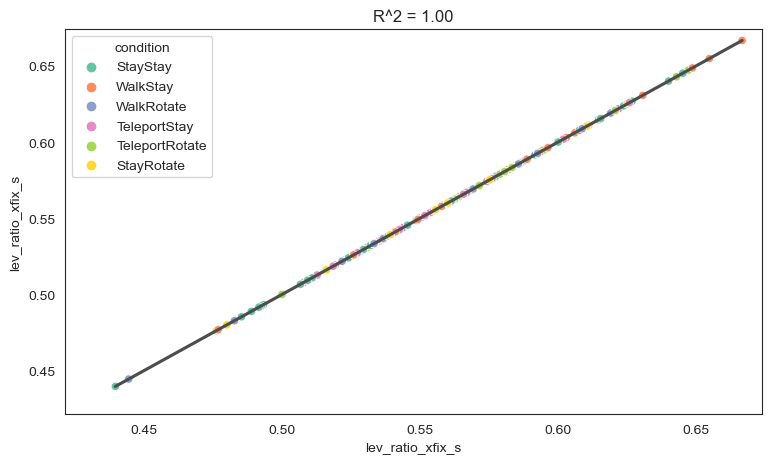

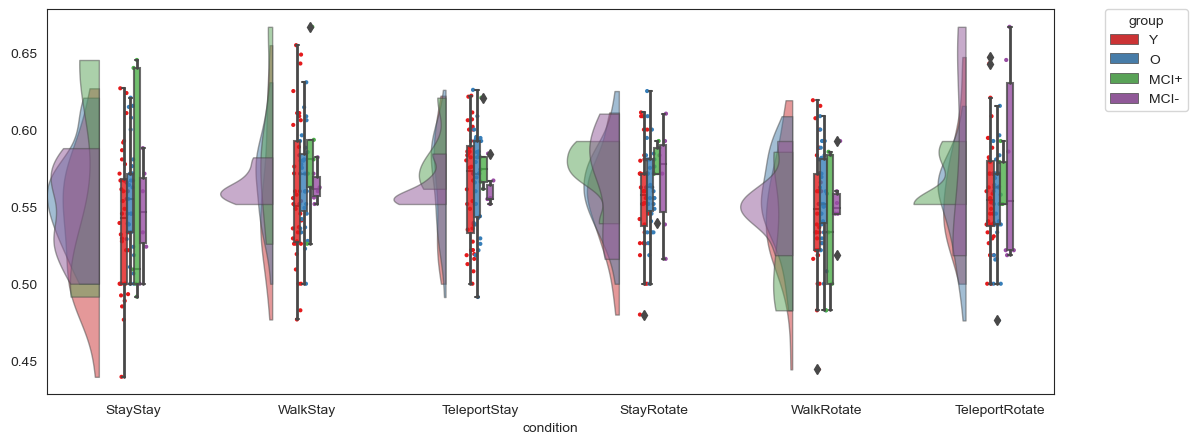

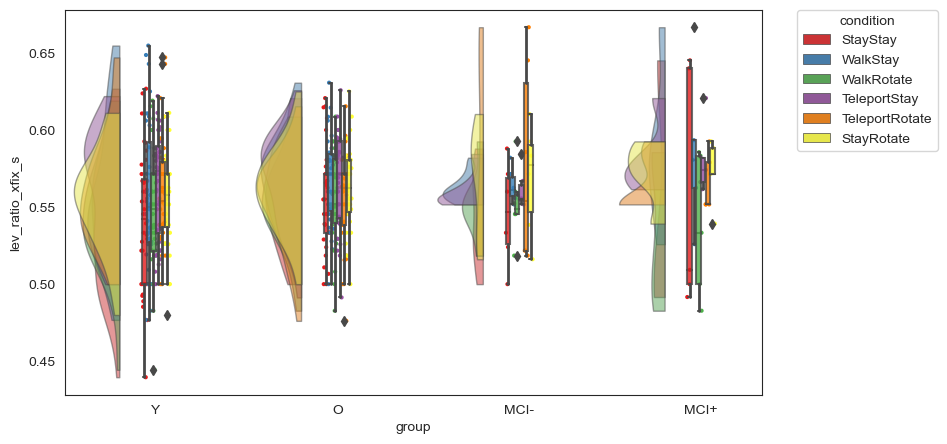

In [11]:
# dwell_MOtabletoSOs_logratio_ret
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
df_plot = df.copy()
combine=False
filter_groups = True
conditions = ['StayStay', 'WalkStay', 'TeleportStay',  'StayRotate', 'WalkRotate', 'TeleportRotate'] #, 'WalkStay', 'TeleportStay']  #, 'TeleportRotate'] #, 'WalkStay', 'StayRotate']  # #, 'WalkStay'] #, 'TeleportRotate']
# conditions = list(np.unique(df.condition.to_list()))

group_filter = ['Y', 'O', 'MCI-', 'MCI+']
group_order = group_plot_order() if not filter_groups else group_filter
# conditions = ['TeleportStay']

print(conditions)
df_plot = df_plot[df_plot.condition.isin(conditions)]
df_plot = df_plot[df_plot.group.isin(group_filter)] if filter_groups else df_plot


x_col = 'lev_ratio_xfix_s'
y_col = 'lev_ratio_xfix_s'

# Initialize figure and ax
f, ax = plt.subplots(figsize=(9, 5))

sns.scatterplot(data=df_plot, x=x_col, y=y_col, hue='condition',palette="Set2", alpha=1, ax=ax)
sns.regplot(data=df_plot, x=x_col, y=y_col, ax=ax, scatter_kws={'alpha':0.0}, line_kws={'color': [0.3, 0.3, 0.3]})
# Fit a linear regression model
data = df.dropna(subset=[x_col, y_col])
reg = LinearRegression().fit(data[[x_col]], data[y_col])
r2 = r2_score(data[y_col],  reg.predict(data[[x_col]]))
plt.title(f"R^2 = {r2:.2f}")
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax_lim_space_scalar = 0.2
ax.set_xlim([np.min(data[x_col]) - (ax_lim_space_scalar * np.std(data[x_col])),
             np.max(data[x_col]) + (ax_lim_space_scalar * np.std(data[x_col]))])
ax.set_ylim([np.min(data[y_col]) - (ax_lim_space_scalar * np.std(data[y_col])),
             np.max(data[y_col]) + (ax_lim_space_scalar * np.std(data[y_col]))])

sns.set_style('white')
# Initialize figure and ax
f, ax = plt.subplots(figsize=(13, 5))
raincloud_alpha = 0.5
rain_size = 4
palette = "Set1"

# Create the raincloud plot
if len(conditions) > 1 and combine is False and filter_groups is False:
    pt.RainCloud(y=x_col, x='group', hue='condition',  data=df_plot, palette=palette, bw=.2,
             width_viol=.5, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, dodge=True, point_size=rain_size, order=group_order)

elif combine is True:
    df_group = df_plot[['ppt_id', x_col]].groupby('ppt_id').mean()
    df_group['group'] = df_plot[['ppt_id', 'group']].groupby('ppt_id').first()
    pt.RainCloud(y=x_col, x='group', data=df_group, palette=palette, bw=.5,
                 width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, order=group_order)
elif filter_groups and len(group_filter) > 1:
    print('test')
    pt.RainCloud(y=x_col, x='condition', hue = 'group', data=df_plot, palette=palette, bw=.5, dodge=True,
                 width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, order=conditions)
elif filter_groups:
    pt.RainCloud(y=x_col, x='condition', data=df_plot, palette=palette, bw=.5,
                 width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, order=conditions)
else:
    pt.RainCloud(y=x_col, x='group', data=df_plot, palette=palette, bw=.2,
                 width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, order=group_order)
ax.set_ylabel('')
# Show the plot
plt.show()
sns.set_style('white')
# Initialize figure and ax
f, ax = plt.subplots(figsize=(9, 5))

# Create the raincloud plot
if len(conditions) > 1 and combine is False:
    pt.RainCloud(y=y_col, x='group', hue='condition',  data=df_plot, palette=palette, bw=.5,
                 width_viol=.5, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha, dodge=True,  order=group_order)
elif combine is True:
    df_group = df_plot[['ppt_id', y_col]].groupby('ppt_id').mean()
    df_group['group'] = df_plot[['ppt_id', 'group']].groupby('ppt_id').first()
    pt.RainCloud(y=y_col, x='group', data=df_group, palette=palette, bw=.2,
                 width_viol=.5, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha,  order=group_order)
else:
    pt.RainCloud(y=y_col, x='group', data=df_plot, palette=palette, bw=.2,
                 width_viol=.5, ax=ax, orient='v', pointplot=False, alpha=raincloud_alpha,  order=group_order)

# Show the plot
plt.show()

In [ ]:
# more wrangling

from sklearn import preprocessing

X = df.drop(['ppt_id'], axis=1).dropna().reset_index(drop=True)
c = X['condition']
X = X.drop(['condition'], axis=1)

replace_map = {'P': 0, 'O': 1, 'Y': 2}
X['group'] = X['group'].replace(replace_map)

y = X['group']
X = X.drop(['group'], axis=1)
X_cols = X.columns
# X_cols = X.columns

# replace with multiple imputation at some point
for col in X.columns:
    # print(col)
    X[col] = X[col].fillna(np.nanmean(X[col]))
    
Xs = preprocessing.StandardScaler().fit(X).transform(X)
Xs_df = pd.DataFrame(Xs, columns=X_cols)
Xs_df['group'] = y
Xs_df['condition'] = c
Xsg = Xs_df.groupby(by='group').mean()
Xs_df = Xs_df.drop(['group'], axis=1)

display(Xs_df.head(20).style)

In [5]:
# save to csv
dir = "C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\"
file_name = "conds_cleaned"
file_path = dir + f"{file_name}.csv"
df.to_csv(file_path, index=False)


In [8]:
# within groups, difference between conditions

p_thresh = 0.05
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
anova_filt_cols = [[], [], []]
groups=['P', 'O', 'Y'] 

for col in Xs_df.columns:
    if col != 'condition' and col != 'group':
        P = Xs_df[y == 0]
        O = Xs_df[y == 1]
        Y = Xs_df[y == 2]
        dfs = [P, O, Y]
        for i in range(3):
            df = dfs[i]
            SS = df[col][df.condition == 'StayStay']
            WS = df[col][df.condition == 'WalkStay']
            TS = df[col][df.condition == 'TeleportStay']
            SR = df[col][df.condition == 'StayRotate']
            WR = df[col][df.condition == 'WalkRotate']
            TR = df[col][df.condition == 'TeleportRotate']

            fvalue, pvalue = stats.f_oneway(SS, WS, TS, SR, WR, TR)
            if pvalue < p_thresh:
                print(f"group {groups[i]}, col: {col}, f: {fvalue:.3f}, p: {pvalue:.3f})")
                anova_filt_cols[i].append(col)

group O, col: p_correct, f: 5.993, p: 0.000)
group Y, col: p_correct, f: 7.276, p: 0.000)
group Y, col: hn_ret, f: 4.718, p: 0.000)
group O, col: dwell_obj1_ret, f: 2.978, p: 0.015)
group Y, col: dwell_obj1_ret, f: 8.215, p: 0.000)
group O, col: dwell_other_ret, f: 3.330, p: 0.008)
group P, col: t_first_array_ret, f: 6.203, p: 0.000)
group O, col: t_first_array_ret, f: 9.735, p: 0.000)
group Y, col: t_first_array_ret, f: 5.491, p: 0.000)
group Y, col: hn_diff, f: 2.985, p: 0.013)
group O, col: dwell_total_diff, f: 3.386, p: 0.007)
group O, col: dwell_obj1_diff, f: 4.444, p: 0.001)
group Y, col: dwell_obj1_diff, f: 7.942, p: 0.000)
group Y, col: dwell_other_diff, f: 2.983, p: 0.013)
group P, col: t_first_array_diff, f: 4.687, p: 0.002)
group O, col: t_first_array_diff, f: 3.295, p: 0.008)
group Y, col: t_first_array_diff, f: 6.985, p: 0.000)
group Y, col: pupil_diam_centre_diff, f: 6.014, p: 0.000)
group Y, col: pupil_diam_spread_diff, f: 3.086, p: 0.011)
group Y, col: dispersion_mean_r

In [16]:
# within conditions, difference between group pairs

p_thresh = 0.05
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
anova_filt_cols_conditions = []
conditions=['StayStay', 'WalkStay', 'TeleportStay', 'StayRotate', 'WalkRotate', 'TeleportRotate'] 
import itertools
group_codes = [0, 1, 2]
pairs = list(itertools.combinations(group_codes, 2))
print(pairs)
for pair in pairs:
    g1, g2 = pair
    g_df = Xs_df[(y == g1) | (y == g2)]
    for col in Xs_df.columns:
        if col != 'condition' and col != 'group':
            dfs = []
            for i in range(len(conditions)):
                anova_filt_cols_conditions.append([])
                df = g_df[col][g_df.condition == conditions[i]]
                G1 = df[y == g1]
                G2 = df[y == g2]
                tvalue, pvalue = stats.ttest_ind(G1, G2)
                if pvalue < p_thresh:
                    print(f"{groups[g1]} vs {groups[g2]} {conditions[i]}, col: {col}, t: {tvalue:.3f}, p: {pvalue:.3f})")
                    anova_filt_cols_conditions[i].append(col)

[(0, 1), (0, 2), (1, 2)]
P vs O StayStay, col: hn_enc, t: 2.226, p: 0.035)
P vs O TeleportStay, col: dwell_obj1_enc, t: -2.493, p: 0.020)
P vs O StayStay, col: hn_diff, t: -2.113, p: 0.045)
P vs O TeleportStay, col: dwell_obj1_diff, t: 2.385, p: 0.025)
P vs O StayRotate, col: t_first_array_diff, t: -2.476, p: 0.020)
P vs O WalkRotate, col: p_trackloss_enc, t: -2.170, p: 0.040)
P vs O WalkRotate, col: p_trackloss_diff, t: 2.748, p: 0.011)
P vs Y StayStay, col: p_correct, t: -3.697, p: 0.001)
P vs Y TeleportStay, col: p_correct, t: -2.384, p: 0.023)
P vs Y StayRotate, col: p_correct, t: -2.962, p: 0.006)
P vs Y TeleportRotate, col: p_correct, t: -2.657, p: 0.012)
P vs Y StayStay, col: hn_enc, t: 2.106, p: 0.043)
P vs Y WalkRotate, col: hn_enc, t: 2.817, p: 0.008)
P vs Y WalkStay, col: t_first_array_enc, t: 3.245, p: 0.003)
P vs Y TeleportStay, col: t_first_array_enc, t: 3.352, p: 0.002)
P vs Y StayRotate, col: t_first_array_enc, t: 2.571, p: 0.015)
P vs Y WalkRotate, col: t_first_array_e

In [ ]:

def subboxplots(df, cols, xlabs=['SS', 'WS', 'TS', 'SR', 'WR', 'TR']):
    n_cols = 4
    n_rows = int(np.ceil(len(cols)/n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), dpi=100)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.6,
                        top=0.9,
                        wspace=0.6,
                        hspace=0.6)
    ticks = list(replace_map.values())
    labels = list(replace_map.keys())
    for i in range(len(cols)):
        row = int(np.floor(i/n_cols))
        col = i % n_cols
        feat = cols[i]
        plt.sca(axes[row, col])
        df.groupby(by='group').boxplot(column=feat, subplots=False)
        # axes[row, col].set_xticks(ticks)
        axes[row, col].set_xticklabels(xlabs)
        axes[row, col].set_title(feat)